# How to define Personalized driver models

- **Personalized driver models** are learned from the data collected from the specific driver. For instance, the personalized model of driver \#1 is learned using the driving data collected from driver \#1.
- **Average driver models** are learned using the data collected from other nine drivers.

#### Procedure
1. Explore subjetive risk
2. Hyper-paramater tunning for feature importance analysis
##### 2-1 Ego-vehicle signals
##### 2-2 Surrounding vehicle directions
3. MPC cost function design
4. Metrics
5. Evaluation and observation

In [1]:
# Driving style 
# PCA
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [31]:
TIME_VARIANTS = [3]
RISK_THRESHOLD_equ = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
RISK_THRESHOLD_per = [5, 4, 4, 5, 4, 4, 4, 4, 5, 2]

RANDOM_STATE = 123
pickle_name = 'pickle/risk_dynamic_data_' + str(TIME_VARIANTS[0]) + '.pkl'
with open(pickle_name, "rb") as f:
    DATA = pickle.load(f)
            
SUBJECTIVE_RISK = []
for i_evaluator in range(10):
    SUBJECTIVE_RISK_i = []
    for i_lc in DATA:
        SUBJECTIVE_RISK_temp = i_lc['risk_labels']
        score_i = 'score_'+ str(i_evaluator+1)
        SUBJECTIVE_RISK_i.append(SUBJECTIVE_RISK_temp[score_i])
    SUBJECTIVE_RISK.append(SUBJECTIVE_RISK_i)

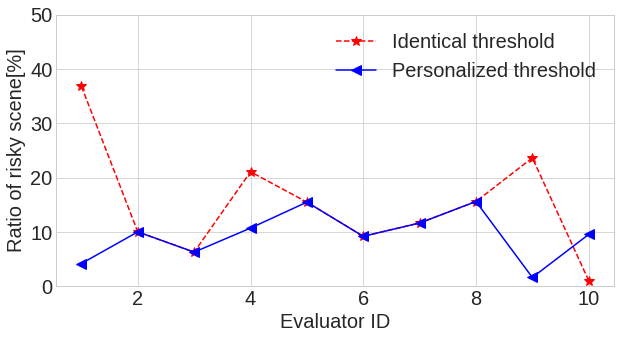

In [32]:
def define_risk_scene():
    percentage_equ = []
    percentage_per = []
    plt.rcParams["font.size"] = 20
    ids = []
    for i_evaluator in range(10):
        cnt_equ = 0
        SUBJECTIVE_RISK_i = SUBJECTIVE_RISK[i_evaluator]
        for i in SUBJECTIVE_RISK_i:
            if i >= RISK_THRESHOLD_equ[i_evaluator]:
                cnt_equ += 1
        percentage_equ.append(cnt_equ*100/len(SUBJECTIVE_RISK_i))
        cnt_per = 0
        for j in SUBJECTIVE_RISK_i:
            if j >= RISK_THRESHOLD_per[i_evaluator]:
                cnt_per += 1
        percentage_per.append(cnt_per*100/len(SUBJECTIVE_RISK_i))
        ids.append(i_evaluator+1)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.plot(ids, percentage_equ, marker="*", markersize=10, markerfacecolor="r", color="r", linestyle="dashed")
    plt.plot(ids, percentage_per, marker="<", markersize=10, markerfacecolor="b", color="b")
    plt.xlabel("Evaluator ID")
    plt.ylabel("Ratio of risky scene[%]")
    plt.legend(("Identical threshold", "Personalized threshold"), loc=1)
    plt.ylim([0, 50])
    
    plt.grid(which='minor',color='black',linestyle='-.')
    #ax.set_xticks(])
    plt.savefig("fig/risky_scenes.png")

define_risk_scene()

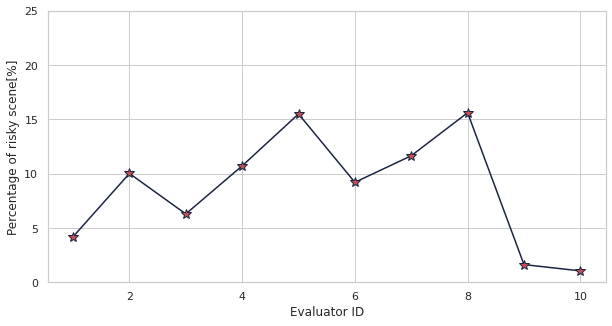

In [113]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
def explore_subjective_risk():
    pickle_name = 'pickle/risk_dynamic_data_' + str(TIME_VARIANTS[0]) + '.pkl'
    with open(pickle_name, "rb") as f:
        DATA = pickle.load(f)
            
    SUBJECTIVE_RISK = []
    for i_evaluator in range(10):
        SUBJECTIVE_RISK_i = []
        for i_lc in DATA:
            SUBJECTIVE_RISK_temp = i_lc['risk_labels']
            score_i = 'score_'+ str(i_evaluator+1)
            SUBJECTIVE_RISK_i.append(SUBJECTIVE_RISK_temp[score_i])
        SUBJECTIVE_RISK.append(SUBJECTIVE_RISK_i)
    #print(SUBJECTIVE_RISK)
    sns.set()
    sns.set_style('whitegrid')
    sns.set_palette('cubehelix')

    fig = plt.figure(figsize=(10, 5))
    #plt.rcParams["font.size"] = 18
    #plt.ylabel('Density')
    #plt.title("Subjective risk evaluation histgram")
    for i_evaluator in range(10):
        SUBJECTIVE_RISK_i = SUBJECTIVE_RISK[i_evaluator]
        #ax = plt.subplot(2,5,i_evaluator+1)
        ax = fig.add_subplot(2,5,i_evaluator+1)
        ax.hist(SUBJECTIVE_RISK_i, density=True)
        ax.set_ylim(0, 3.5)
        ax.set_xlabel('Evaluator #{}'.format(i_evaluator+1))
    plt.tight_layout()
    plt.savefig("fig/subjective_risk_all.png")
    plt.show()

    
    fig2 = plt.figure(figsize=(10, 5))
    ax = fig2.add_subplot(1,1,1)
    ax.hist(SUBJECTIVE_RISK,bins = 5)
    #ax.set_ylim(0, 3.5)
    ax.set_xlabel('Subjective risk of 10 evaluators')
    ax.set_ylabel('# of lane change events')
    plt.tight_layout()
    legends = []
    for i in range(10):
        legends.append('Evaluator #{}'.format(i+1))
        
    plt.legend(legends)
    plt.savefig("fig/subjective_risk_all_bin.png")
    plt.show()
    
        
#explore_subjective_risk()
    
def define_risk_scene():
    percentage = []
    plt.rcParams["font.size"] = 30
    ids = []
    for i_evaluator in range(10):
        cnt = 0
        SUBJECTIVE_RISK_i = SUBJECTIVE_RISK[i_evaluator]
        for i in SUBJECTIVE_RISK_i:
            if i >= RISK_THRESHOLD[i_evaluator]:
                cnt += 1
        percentage.append(cnt*100/len(SUBJECTIVE_RISK_i))
        ids.append(i_evaluator+1)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.plot(ids, percentage, marker="*", markersize=10, markerfacecolor="r")
    plt.xlabel("Evaluator ID")
    plt.ylabel("Percentage of risky scene[%]")
    plt.ylim([0, 25])
    
    plt.grid(which='minor',color='black',linestyle='-.')
    #ax.set_xticks(])
    plt.savefig("fig/risky_scenes.png")

define_risk_scene()

In [1]:
def get_subjective_risk_clf(i_evaluator):
    risk_label_old = SUBJECTIVE_RISK[i_evaluator]
    risk_label_clf = []
    for i in risk_label_old:
        if i >= RISK_THRESHOLD[i_evaluator]:
            risk_label_clf.append(1)
        else:
            risk_label_clf.append(0)
    return risk_label_clf

In [2]:
def get_subjective_risk_clf(i_evaluator):
    risk_label_old = SUBJECTIVE_RISK[i_evaluator]
    risk_label_clf = []
    for i in risk_label_old:
        if i >= RISK_THRESHOLD[i_evaluator]:
            risk_label_clf.append(1)
        else:
            risk_label_clf.append(0)
    return risk_label_clf
def get_input_feature_importance(data_type, risk_label):
    if data_type == 'drv':
        input_data = pd.DataFrame()
        risk_label_reshaped = []
        for i_lc in range(len(DATA)):          
            drv_data_i = DATA[i_lc]['drv_data']   
            input_data = pd.concat([input_data, drv_data_i], axis=0)
            risk_label_extended = np.tile(risk_label[i_lc],(len(drv_data_i),1))
            #print(len(risk_label_extended))
            risk_label_reshaped.extend(risk_label_extended)
    elif data_type == 'surr':
        input_data = pd.DataFrame()
        risk_label_reshaped = []
        for i_lc in range(len(DATA)):          
            surr_data_i = DATA[i_lc]['surr_zones']   
            input_data = pd.concat([input_data, surr_data_i], axis=0)
            risk_label_extended = np.tile(risk_label[i_lc],(len(surr_data_i),1))
            #print(len(risk_label_extended))
            risk_label_reshaped.extend(risk_label_extended)
            
    risk_label_raveled = np.ravel(risk_label_reshaped)

    return input_data, risk_label_raveled

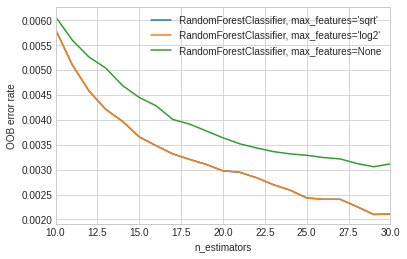

In [6]:
import warnings
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
warnings.simplefilter('ignore')
def analyze_n_feature_importance():
    RANDOM_STATE = 123
    for i_evaluator in range(1):
        risk_label = get_subjective_risk_clf(i_evaluator)
        X, y = get_input_feature_importance('drv', risk_label)
        #get_feature_importance('surr', risk_label)
        
        ensemble_clfs = [
            ("RandomForestClassifier, max_features='sqrt'",
                RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
            ("RandomForestClassifier, max_features='log2'",
                RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
            ("RandomForestClassifier, max_features=None",
                RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
        ]
        
        error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 10
    max_estimators = 30
    
    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))
    
    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.savefig('n_features.png')
    plt.show()
        
        
analyze_n_feature_importance()

In [145]:
rf = RandomForestClassifier(random_state = RANDOM_STATE)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


In [14]:
import warnings
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
warnings.simplefilter('ignore')

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    target_names = ['Safe', 'Risky']
    result = classification_report(y_test, y_pred, target_names=target_names)
    print('Model Performance')
    print(result)
    
def analyze_feature_importance():
    
    for i_evaluator in range(1):
        risk_label = get_subjective_risk_clf(i_evaluator)
        X, y = get_input_feature_importance('drv', risk_label)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 3)]
        # Number of features to consider at every split
        max_features = ['log2']
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(5, 110, num = 5)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]     
        # risky scene class_weight
        class_weight =  [{0: 10, 1: 90}]  
        
        # Create the random grid
        """
        random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight}
        """
        random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap,
               'class_weight': class_weight}
             
        
        pprint(random_grid)
        
        rf = RandomForestClassifier(random_state = RANDOM_STATE)
        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
        rf_random = RandomizedSearchCV(estimator = rf, 
                                       param_distributions = random_grid, 
                                       n_iter = 100, 
                                       cv = 3, 
                                       verbose=2, 
                                       random_state=RANDOM_STATE, 
                                       n_jobs = -1)
        
        rf_random.fit(X_train, y_train)
        print(rf_random.best_params_)
        
        base_model = RandomForestClassifier(n_estimators = 10, random_state = RANDOM_STATE,
                                           class_weight = {0: 50, 1: 50})
        base_model.fit(X_train, y_train)
        base_accuracy = evaluate(base_model, X_test, y_test)
        
        best_random = rf_random.best_estimator_
        best_accuracy = evaluate(best_random, X_test, y_test)
    
        
analyze_feature_importance()

{'bootstrap': [True, False],
 'class_weight': [{0: 10, 1: 90}],
 'max_depth': [5, 31, 57, 83, 110, None],
 'max_features': ['log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 55, 100]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   56.6s


KeyboardInterrupt: 

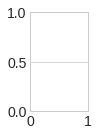

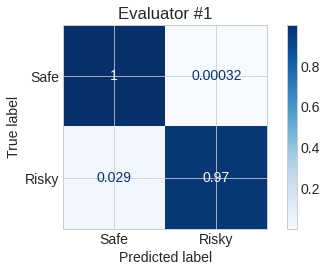

0


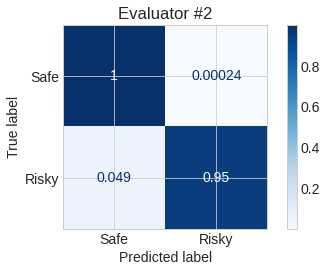

1


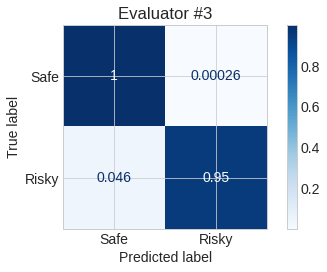

2


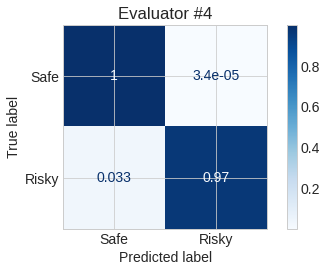

3


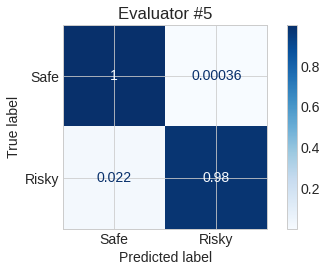

4


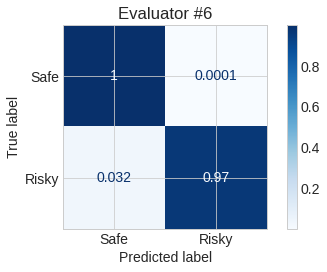

5


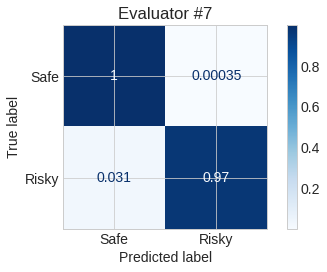

6


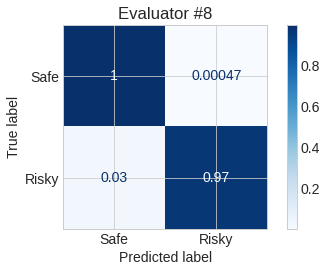

7


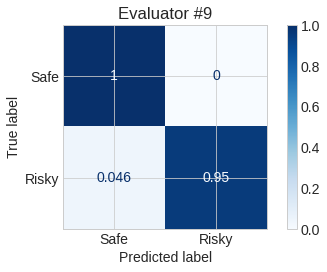

8


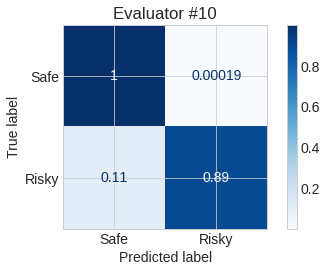

9


In [35]:
import warnings
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pprint import pprint
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
warnings.simplefilter('ignore')

def show_feature_importance():
    fig = plt.figure()
    plt.rcParams["font.size"] = 14
    for i_evaluator in range(10):
        risk_label = get_subjective_risk_clf(i_evaluator)
        X, y = get_input_feature_importance('drv', risk_label)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        # Number of trees in random forest
        n_estimators = 100
        # risky scene class_weight
        class_weight =  {0: 10, 1: 90}

        rf = RandomForestClassifier(random_state = RANDOM_STATE, 
                                    n_estimators = n_estimators,
                                    class_weight = class_weight, 
                                    max_features = 'log2')
        
        rf.fit(X_train, y_train)
        labels = ['Safe', 'Risky']
        
        ax = fig.add_subplot(2,5,i_evaluator+1)
        plot_confusion_matrix(rf, X_test, y_test, display_labels=labels,cmap=plt.cm.Blues,normalize='true')
        plt.title('Evaluator #{}'.format(i_evaluator+1))
        pic_title = 'fig/confusion_matrix_feature_importance_' + str(i_evaluator+1) + '.png'
        plt.savefig(pic_title)
        plt.tight_layout()
        plt.show()
        print(i_evaluator)

show_feature_importance()

Handline Evaluator #0
Handline Evaluator #1
Handline Evaluator #2
Handline Evaluator #3
Handline Evaluator #4
Handline Evaluator #5
Handline Evaluator #6
Handline Evaluator #7
Handline Evaluator #8
Handline Evaluator #9


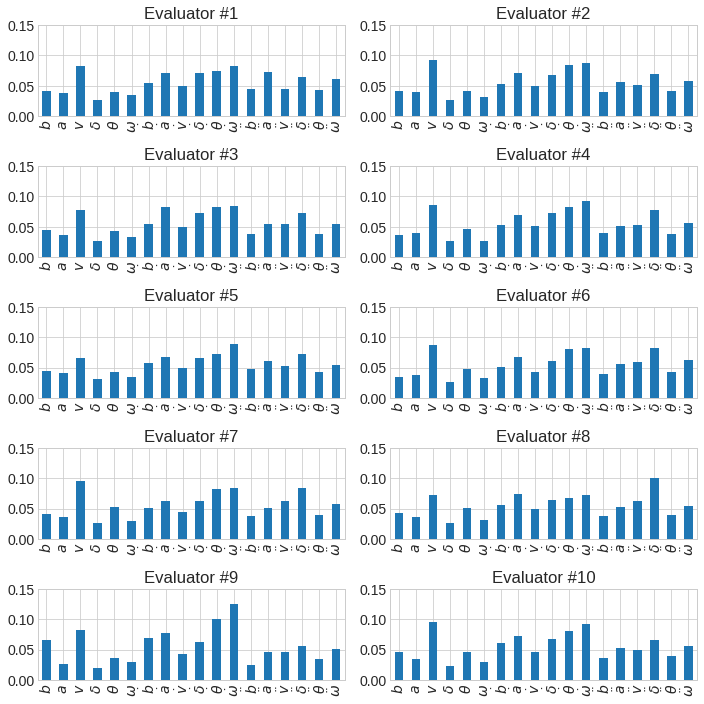

In [35]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
warnings.simplefilter('ignore')

def get_subjective_risk_clf(i_evaluator):
    risk_label_old = SUBJECTIVE_RISK[i_evaluator]
    risk_label_clf = []
    for i in risk_label_old:
        if i >= RISK_THRESHOLD_per[i_evaluator]:
            risk_label_clf.append(1)
        else:
            risk_label_clf.append(0)
    return risk_label_clf

def get_input_feature_importance(data_type, risk_label):
    if data_type == 'drv':
        input_data = pd.DataFrame()
        risk_label_reshaped = []
        for i_lc in range(len(DATA)):          
            drv_data_i = DATA[i_lc]['drv_data']   
            input_data = pd.concat([input_data, drv_data_i], axis=0)
            risk_label_extended = np.tile(risk_label[i_lc],(len(drv_data_i),1))
            #print(len(risk_label_extended))
            risk_label_reshaped.extend(risk_label_extended)
    elif data_type == 'surr':
        input_data = pd.DataFrame()
        risk_label_reshaped = []
        for i_lc in range(len(DATA)):          
            surr_data_i = DATA[i_lc]['surr_zones']   
            input_data = pd.concat([input_data, surr_data_i], axis=0)
            risk_label_extended = np.tile(risk_label[i_lc],(len(surr_data_i),1))
            #print(len(risk_label_extended))
            risk_label_reshaped.extend(risk_label_extended)
            
    risk_label_raveled = np.ravel(risk_label_reshaped)

    return input_data, risk_label_raveled

def show_drv_feature_importance():
    fig = plt.figure(figsize= (10,10))
    plt.rcParams["font.size"] = 14
    
    for i_evaluator in range(10):
        risk_label = get_subjective_risk_clf(i_evaluator)
        X, y = get_input_feature_importance('drv', risk_label)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        # Number of trees in random forest
        n_estimators = 100
        # risky scene class_weight
        class_weight =  {0: 10, 1: 90}

        rf = RandomForestClassifier(random_state = RANDOM_STATE, 
                                    n_estimators = n_estimators,
                                    class_weight = class_weight, 
                                    max_features = 'log2')
        
        rf.fit(X_train, y_train)
        labels = ['Safe', 'Risky']
        
        """
        fet_ind = np.argsort(rf.feature_importances_)[::-1]
        fet_imp = rf.feature_importances_[fet_ind]
        """
        fet_imp = rf.feature_importances_
        
        ax = plt.subplot(5, 2, i_evaluator+1)
        X_train.columns = ['$b$', '$a$', '$v$', r'$\delta$', r'$\theta$', '$\omega$',
                        '$\dot{b}$', '$\dot{a}$', '$\dot{v}$', r'$\dot{\delta}$', r'$\dot{\theta}$', '$\dot{\omega}$',
                        '$\ddot{b}$', '$\ddot{a}$', '$\ddot{v}$', r'$\ddot{\delta}$', r'$\ddot{\theta}$', '$\ddot{\omega}$']

        #labels = feature_name[fet_ind]
        #labels = feature_name[fet_ind]
        
        pd.Series(fet_imp, index=X_train.columns).plot(kind='bar', ax=ax)
        ax.set_title('Evaluator #{}'.format(i_evaluator+1))
        ax.set_ylim([0, 0.15])
        plt.tight_layout()
        
        print('Handline Evaluator #{}'.format(i_evaluator))
    plt.savefig('fig/drv_signal_feature_importance_all5.png')
    plt.show()

show_drv_feature_importance()

Index(['zone_1_x', 'zone_1_y', 'zone_2_x', 'zone_2_y', 'zone_3_x', 'zone_3_y',
       'zone_4_x', 'zone_4_y', 'zone_5_x', 'zone_5_y'],
      dtype='object')
Index(['zone_1_x', 'zone_1_y', 'zone_2_x', 'zone_2_y', 'zone_3_x', 'zone_3_y',
       'zone_4_x', 'zone_4_y', 'zone_5_x', 'zone_5_y'],
      dtype='object')
Index(['zone_1_x', 'zone_1_y', 'zone_2_x', 'zone_2_y', 'zone_3_x', 'zone_3_y',
       'zone_4_x', 'zone_4_y', 'zone_5_x', 'zone_5_y'],
      dtype='object')
Index(['zone_1_x', 'zone_1_y', 'zone_2_x', 'zone_2_y', 'zone_3_x', 'zone_3_y',
       'zone_4_x', 'zone_4_y', 'zone_5_x', 'zone_5_y'],
      dtype='object')
Index(['zone_1_x', 'zone_1_y', 'zone_2_x', 'zone_2_y', 'zone_3_x', 'zone_3_y',
       'zone_4_x', 'zone_4_y', 'zone_5_x', 'zone_5_y'],
      dtype='object')
Index(['zone_1_x', 'zone_1_y', 'zone_2_x', 'zone_2_y', 'zone_3_x', 'zone_3_y',
       'zone_4_x', 'zone_4_y', 'zone_5_x', 'zone_5_y'],
      dtype='object')
Index(['zone_1_x', 'zone_1_y', 'zone_2_x', 'zone_2_y', 'zo

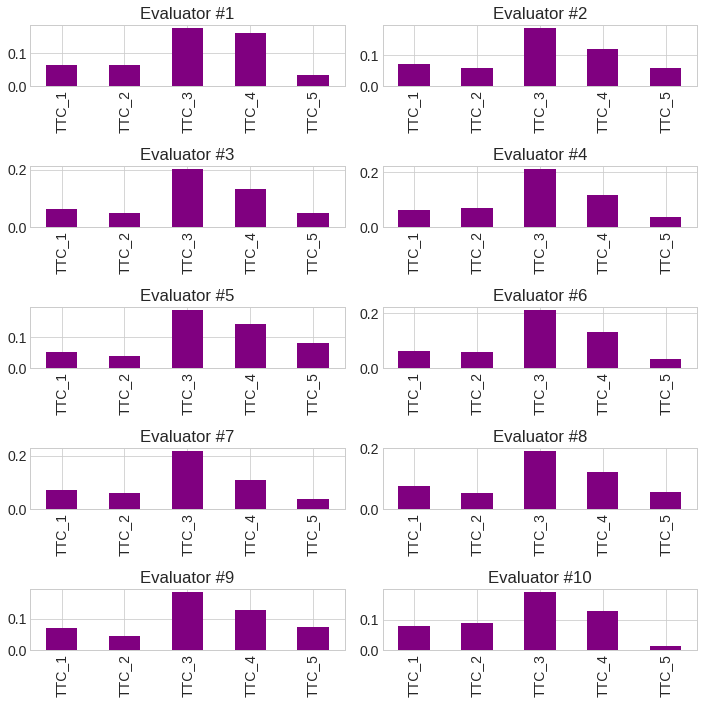

In [18]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
warnings.simplefilter('ignore')


def show_surr_feature_importance():
    fig = plt.figure(figsize= (10,10))
    plt.rcParams["font.size"] = 14
    
    for i_evaluator in range(10):
        risk_label = get_subjective_risk_clf(i_evaluator)
        X, y = get_input_feature_importance('surr', risk_label)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        # Number of trees in random forest
        n_estimators = 3
        # risky scene class_weight
        class_weight =  {0: 10, 1: 90}

        rf = RandomForestClassifier(random_state = RANDOM_STATE, 
                                    n_estimators = n_estimators,
                                    class_weight = class_weight, 
                                    max_features = 'log2')
        
        rf.fit(X_train, y_train)
        labels = ['Safe', 'Risky']
        
        """
        fet_ind = np.argsort(rf.feature_importances_)[::-1]
        fet_imp = rf.feature_importances_[fet_ind]
        """
        fet_imp = rf.feature_importances_
        
        ax = plt.subplot(5, 2, i_evaluator+1)
        """
        X_train.columns = ['$b$', '$a$', '$v$', r'$\theta$', '$l$', '$\omega$',
                        '$\dot{b}$', '$\dot{a}$', '$\dot{v}$', r'$\dot{\theta}$', '$\dot{l}$', '$\dot{\omega}$',
                        '$\ddot{b}$', '$\ddot{a}$', '$\ddot{v}$', r'$\ddot{\theta}$', '$\ddot{l}$', '$\ddot{\omega}$']
                        """

        #labels = feature_name[fet_ind]
        #labels = feature_name[fet_ind]
        
        new_fea_imp = []
        j = 0 
        index = []
        for i in range(5):
            new_fea_imp.append((fet_imp[j]+fet_imp[j+1])/2)
            j += 2
            index.append('TTC_'+str(i+1))
            
        
        pd.Series(new_fea_imp).plot(kind='bar', ax=ax, color='purple')
        ax.set_title('Evaluator #{}'.format(i_evaluator+1))
        #ax.set_ylim([0, 0.5])
        plt.xticks([0,1,2,3,4],index)
        plt.tight_layout()
        
    plt.savefig('fig/surr_signal_feature_importance_all.png')
    plt.show()

show_surr_feature_importance()

#### 3. Simulation
- Lane change scenarios

In [ ]:
gmm5= [14.646659083823453, 15.404403797825733, 9.653483429250576, 11.229009796558874, 12.126119618255698, 8.806966396290479, 13.012201020973853, 17.698201643430664, 14.019224156260467, 9.598311021815361]

#### 4. Personalized data driven control
1. Personalized MPC
2. Risk adaptive control
3. Data-driven control
  - Training phase
  - Inference phase


#### 5.Experimental result
- KL divergence
- MSE
- Interrupting time
- Subjective risk evaluation